In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load train data
train = pd.read_csv('microarray_train.csv', index_col=0)

# seprate target from features
target = train.pop('cancer')

# negative values relaced with 0
train = train.mask(train < 0, 0)
train = np.log2(train + 1)

# check if features with all zero values
zeros = (train==0).sum(axis=0)
allzeros = (zeros == len(train.index))
print('num features all zero:', allzeros.sum())

zerocols = list(allzeros[allzeros==True].index)
train = train.drop(columns=zerocols)

print(train.shape)
train.head()

num features all zero: 396
(38, 6733)


,AFFX-BioB-5_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioDn-3_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.000000,6.475733,7.643856,7.982994,7.693487,0.000000,6.247928,8.577429,0.000000,...,7.539159,9.000000,0.000000,8.607330,0.00000,9.632995,8.366322,5.209453,7.584963,0.0
1,0.0,0.000000,8.149747,0.000000,6.672425,6.228819,4.321928,7.515700,7.366322,0.000000,...,7.409391,9.710806,0.000000,8.791163,0.00000,9.612868,8.209453,3.584963,6.266787,0.0
2,0.0,0.000000,8.276124,5.087463,7.693487,0.000000,4.321928,7.707359,8.758223,6.409391,...,8.303781,10.228819,5.087463,7.400879,5.72792,10.153552,9.603626,5.392317,7.839204,0.0
3,0.0,8.055282,3.700440,7.312883,5.643856,5.000000,8.507795,7.159871,8.087463,0.000000,...,7.912889,9.707359,7.774787,7.451211,0.00000,9.294621,7.417853,0.000000,6.988685,0.0
4,0.0,0.000000,7.400879,2.321928,6.149747,7.982994,7.285402,5.044394,7.741467,1.000000,...,7.294621,9.344296,5.857981,8.980140,0.00000,7.971544,8.299208,3.906891,5.832890,0.0


In [3]:
# label encode target, ALL:0, AML:1
le = LabelEncoder()
target = le.fit_transform(target)
print(le.classes_)

['ALL' 'AML']


#### Baseline Model

In [4]:
# baseline

# stratified 5 fold split of data
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=1))
    ])
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

Scores: [0.75, 0.75, 0.625, 0.7142857142857143, 0.7142857142857143]


In [5]:
# create metrics df
def generate_metrics(df,target):    
    metrics = pd.DataFrame(index=train.columns)
    # compute percent of intensity values > 0 for each feature
    metrics['pctvalpos'] = [sum(df[col]>0)/len(df[col]) for col in df.columns]
    # compute mutual info for features
    metrics['mi'] = mutual_info_classif(df, target, random_state=123)
    
    # compute regular p-values for each feature between ALL/0 and AML/1 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], equal_var=False)[1]) # store p-val
    metrics['pval'] = pval
    
    # compute adjusted p-values for each feature between ALL and AML with permutations 
    pval=[]
    for col in df.columns:
        pval.append(stats.ttest_ind(df.loc[target==1,col], df.loc[target==0,col], \
                                    permutations=5000, random_state=123,equal_var=False)[1]) # store p-val
    metrics['adj_pval'] = pval    

    return metrics

met = generate_metrics(train, target)
met.describe()


,pctvalpos,mi,pval,adj_pval
count,6733.000000,6733.000000,6.733000e+03,6733.000000
mean,0.754293,0.052042,3.619464e-01,0.389671
std,0.318594,0.072487,3.084091e-01,0.321626
min,0.026316,0.000000,2.061858e-10,0.000000
25%,0.552632,0.000000,6.915102e-02,0.077800
50%,0.947368,0.018912,3.031255e-01,0.334400
75%,1.000000,0.082276,6.208379e-01,0.665400
max,1.000000,0.566292,9.999199e-01,1.000000


In [6]:
# drop features based on metrics
def dropfeat(df, metricsdf):
    dropcol = metricsdf[metricsdf['pctvalpos'] < 0.6].index
    #dropcol = metricsdf[metricsdf['adj_pval'] > 0.01].index
    dropcol = dropcol.append(metricsdf[metricsdf['adj_pval'] > 0.0006].index)
    #dropcol = dropcol.append(metricsdf[metricsdf['pval'] > 0.001].index)
    dropcol = dropcol.append(metricsdf[metricsdf['mi'] < 0.4].index)
    
    dropcol = dropcol.unique()
    df = df.drop(dropcol, axis=1)
    #print(df.shape)
    return df

In [7]:
# generate list of correlated features to drop
def generate_corr(df, threshold, metricsdf):
    # set cut off threshold
    threshold = threshold
    # compute correlation matrix, take absolute value 
    corrmat = df.corr().abs() 
    
    # find feature pairs with correlation coefficients above threshold
    r = []
    c = []
    coeff = []
    for row in range(len(corrmat.columns)):
        for col in range(row): # stops at diagonal
            # check if above threshold
            if corrmat.iloc[row,col] >= threshold:
                # store row, column, coefficient
                r.append(row)
                c.append(col)
                coeff.append(corrmat.iloc[row,col])
                
    # make df with row and col pairs sorted by correlation coefficient
    corrdf = pd.DataFrame()
    corrdf['r'] = r
    corrdf['c'] = c
    corrdf['coeff'] = coeff
    #print(corrdf)
    # sort by coefficient
    corrdf = corrdf.sort_values(by=['coeff'], ascending=False)
    #print(corrdf)
    
    # choose correlated features to drop based on p-value
    corrcol = []
    for entry in range(len(corrdf)):
        row = corrdf.loc[entry,'r']
        col = corrdf.loc[entry,'c']
        # check which has higher mi score, if already in corrcol
        if metrics.loc[corrmat.columns[col],'mi'] < metrics.loc[corrmat.columns[row],'mi'] \
        and (corrmat.columns[col] not in corrcol):
            # add to corrcol list
            corrcol.append(corrmat.columns[col])
        elif metrics.loc[corrmat.columns[col],'mi'] > metrics.loc[corrmat.columns[row],'mi'] \
        and (corrmat.columns[row] not in corrcol):
            corrcol.append(corrmat.columns[row])
            
    return corrcol
#trainx = trainx.drop(corrcol, axis=1)


In [8]:
# stratified 5 fold split of data
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    # create metrics df, drop features based on metrics
    metrics = generate_metrics(trainx, trainy)
    trainx = dropfeat(trainx, metrics)
    testx = dropfeat(testx, metrics)
    #print(trainx.shape)
    
    # find correlated features, drop features
    corrcol = generate_corr(trainx, threshold=0.5, metricsdf=metrics)
    trainx = trainx.drop(corrcol, axis=1)
    testx = testx.drop(corrcol, axis=1)
    print(trainx.shape)
    
    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        #('svc', SVC(C=1)),
        ('svc', SVC(C=1, class_weight='balanced'))
    ])   
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

(30, 4)
(30, 2)
(30, 2)
(31, 2)
(31, 3)
Scores: [1.0, 1.0, 0.75, 1.0, 0.8571428571428571]


(3, 3)


<AxesSubplot:>

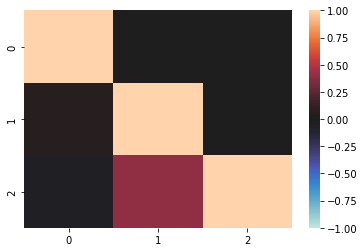

In [9]:
# check correlation of remaining features
corrmat = trainx.corr()
#print(corrmat)

print(corrmat.shape)
sns.heatmap(np.tril(corrmat), vmin=-1,vmax=1, center=0)

In [10]:
# parameter optimization test
skf = StratifiedKFold(n_splits=5)
scores = []
for trainidx, testidx in skf.split(train, target):
    trainx, trainy = train.loc[trainidx, :], target[trainidx]
    testx, testy = train.loc[testidx], target[testidx]
    
    # create metrics df, drop features based on metrics
    metrics = generate_metrics(trainx, trainy)
    trainx = dropfeat(trainx, metrics)
    testx = dropfeat(testx, metrics)
    #print(trainx.shape)
    
    # find correlated features, drop features
    corrcol = generate_corr(trainx, threshold=0.5, metricsdf=metrics)
    trainx = trainx.drop(corrcol, axis=1)
    testx = testx.drop(corrcol, axis=1)
    #print(trainx.shape)
    
    # model pipeline
    svcpipe = Pipeline([
        ('scaler', StandardScaler()),
        #('svc', SVC(C=1)),
        ('svc', SVC(C=0.1, class_weight='balanced'))
    ])   
    
    svcpipe.fit(trainx, trainy)
    scores.append(svcpipe.score(testx, testy))
    
print(f'Scores: {scores}')

Scores: [0.875, 1.0, 0.625, 0.5714285714285714, 0.8571428571428571]


#### Final Model

In [11]:
trainx = pd.read_csv('microarray_train.csv', index_col=0)
trainy = trainx.pop('cancer')

testx = pd.read_csv('microarray_test.csv', index_col=0)
testy = testx.pop('cancer')

# negative values relaced with 0
trainx = trainx.mask(trainx < 0, 0)
trainx = np.log2(trainx + 1)

testx = testx.mask(testx < 0, 0)
testx = np.log2(testx + 1)

# drop features with all zero values
zeros = (trainx==0).sum(axis=0)
allzeros = (zeros == len(trainx.index))
print('num features all zero:', allzeros.sum())

zerocols = list(allzeros[allzeros==True].index)
trainx = trainx.drop(columns=zerocols)
testx = testx.drop(columns=zerocols)

print('train shape:', trainx.shape)
print('test shape:', testx.shape)

num features all zero: 396
train shape: (38, 6733)
test shape: (34, 6733)


In [12]:
# final model

# label encode target, ALL:0, AML:1
le = LabelEncoder()
trainy = le.fit_transform(trainy)
testy = le.fit_transform(testy)
print(f'classes: {le.classes_}')

# create metrics df, drop features based on metrics
metrics = generate_metrics(trainx, trainy)
trainx = dropfeat(trainx, metrics)
testx = dropfeat(testx, metrics)
print(f'shape after metrics filter: {trainx.shape}')

# find correlated features, drop features
corrcol = generate_corr(trainx, threshold=0.5, metricsdf=metrics)
trainx = trainx.drop(corrcol, axis=1)
testx = testx.drop(corrcol, axis=1)
print(f'shape after correlation filter: {trainx.shape}')

# model pipeline
svcpipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=1, class_weight='balanced'))
])   

svcpipe.fit(trainx, trainy)
svcpipe.score(testx, testy)
    
print(f'Score: {svcpipe.score(testx, testy)}')

classes: ['ALL' 'AML']
shape after metrics filter: (38, 17)
shape after correlation filter: (38, 4)
Score: 0.7941176470588235


(4, 4)


<AxesSubplot:>

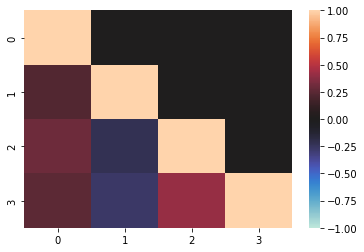

In [13]:
# check correlation of remaining features
corrmat = trainx.corr()
#print(corrmat)
print(corrmat.shape)
sns.heatmap(np.tril(corrmat), vmin=-1,vmax=1, center=0)

In [14]:
# remaining features
trainx.columns

Index(['M21551_rna1_at', 'M77142_at', 'X95735_at', 'M27783_s_at'], dtype='object')

In [15]:
# gene descriptions of remaining features
gene_info = pd.read_csv('gene_info.csv', index_col=0)
#gene_info.head()
geneidx=[]
for genenum in trainx.columns:
    mask = gene_info['Gene Accession Number'].str.match(genenum)
    geneidx.append(list(gene_info[mask].index)[0])
    
print(geneidx)
gene_info.iloc[geneidx,:]

[1806, 2232, 4846, 6217]


,Gene Description,Gene Accession Number
1806,Neuromedin B mRNA,M21551_rna1_at
2232,NUCLEOLYSIN TIA-1,M77142_at
4846,Zyxin,X95735_at
6217,ELA2 Elastatse 2; neutrophil,M27783_s_at
